<a href="https://colab.research.google.com/github/applepieiris/TensorFlow-Advanced-Techniques-Specialization/blob/main/Course%202%20-%20Custom%20and%20Distributed%20Training%20with%20TensorFlow/Week%202/Inception_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the notebook which realize the small inception model adapted for the cifar10 dataset. The model architecture can be found in paper: https://arxiv.org/pdf/1611.03530.pdf. 
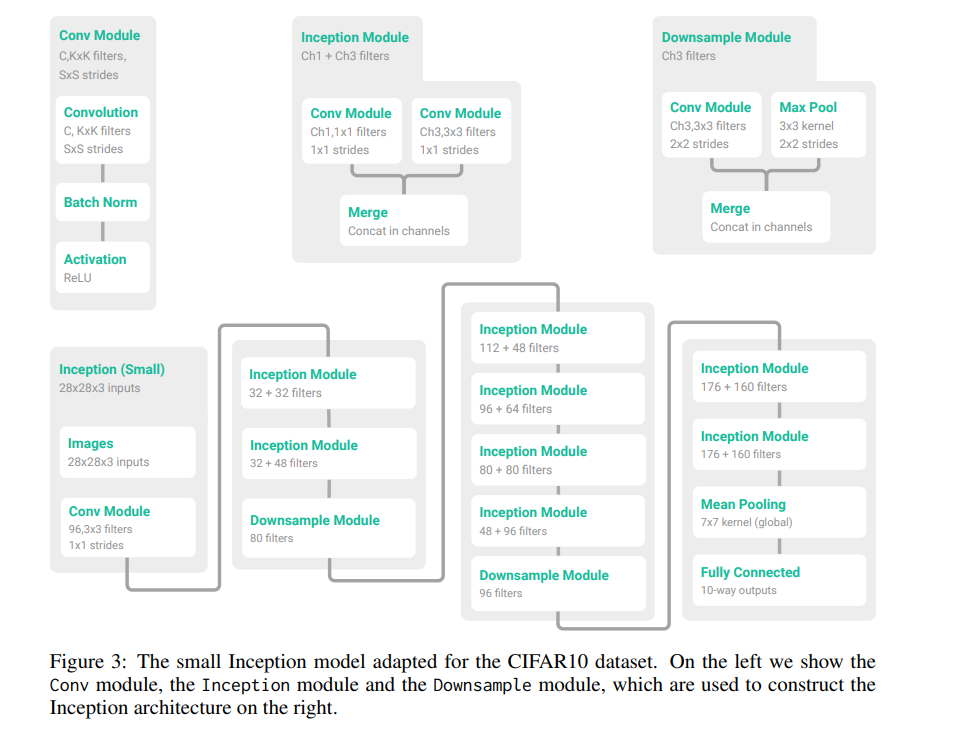

# Data Preparation

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

170498071/170498071 [==============================] - 13s 0us/step
(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


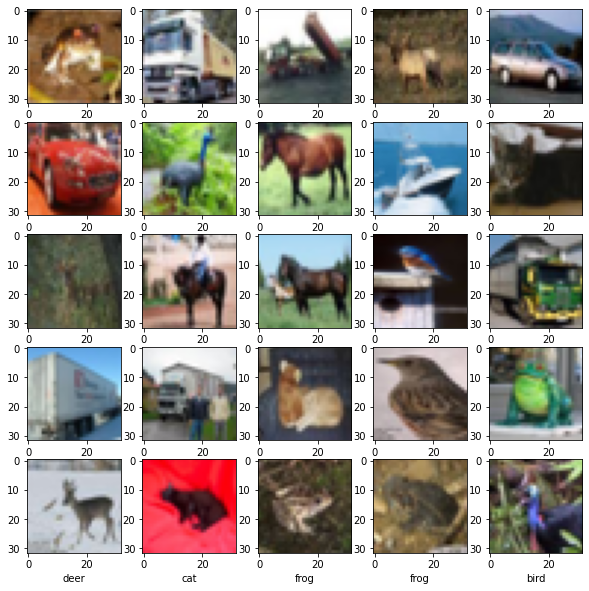

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(x_train.shape, y_train.shape) # (50000, 32, 32, 3) (50000, 1)
print(x_test.shape, y_test.shape)   # (10000, 32, 32, 3) (10000, 1)

# train set / data 
x_train = x_train.astype('float32') / 255

# validation set / data 
x_test = x_test.astype('float32') / 255

# target / class name
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i][0]])

In [3]:
batch_size = 4
# train set / target 
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
# validation set / target 
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)


# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)


# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.batch(batch_size)

In [4]:
for i, (x, y) in enumerate(train_dataset):
    print(x.shape, y.shape)
    
    if i == 2:
        break


for i, (x, y) in enumerate(val_dataset):
    print(x.shape, y.shape)
    
    if i == 2:
       break

(4, 32, 32, 3) (4, 10)
(4, 32, 32, 3) (4, 10)
(4, 32, 32, 3) (4, 10)
(4, 32, 32, 3) (4, 10)
(4, 32, 32, 3) (4, 10)
(4, 32, 32, 3) (4, 10)


# Inception Model 

In [5]:
class ConvModule(tf.keras.layers.Layer):
     def __init__(self, kernel_num, kernel_size, strides, padding='same'):
        super(ConvModule, self).__init__()
        # conv layer
        self.conv = tf.keras.layers.Conv2D(
                    kernel_num, 
                    kernel_size=kernel_size, 
                    strides=strides, 
                    padding=padding
                )
        # batch norm layer

        self.bn   = tf.keras.layers.BatchNormalization()


     def call(self, input_tensor, training=False):
        x = self.conv(input_tensor)
        x = self.bn(x, training=training)
        x = tf.nn.relu(x)
        return x
class InceptionModule(tf.keras.layers.Layer):
    def __init__(self, kernel_size1x1, kernel_size3x3):
        super(InceptionModule, self).__init__()
        # two conv modules: they will take same input tensor 
        self.conv1 = ConvModule(
                        kernel_size1x1, kernel_size=(1,1), strides=(1,1)
                      )
        self.conv2 = ConvModule(
                        kernel_size3x3, kernel_size=(3,3), strides=(1,1)
                      )
        self.cat   = tf.keras.layers.Concatenate()


    def call(self, input_tensor, training=False):
        x_1x1 = self.conv1(input_tensor)
        x_3x3 = self.conv2(input_tensor)
        x = self.cat([x_1x1, x_3x3])
        return x

class DownsampleModule(tf.keras.layers.Layer):
    def __init__(self, kernel_size):
        super(DownsampleModule, self).__init__()
        # conv layer
        self.conv3 = ConvModule(
                  kernel_size, 
                  kernel_size=(3,3), 
                  strides=(2,2), 
                  padding="valid"
              ) 

        # pooling layer 
        self.pool  = tf.keras.layers.MaxPooling2D(
                  pool_size=(3, 3), 
                  strides=(2,2)
              )
        self.cat   = tf.keras.layers.Concatenate()


    def call(self, input_tensor, training=False):
            # forward pass 
            conv_x = self.conv3(input_tensor, training=training)
            pool_x = self.pool(input_tensor)

            # merged
            return self.cat([conv_x, pool_x])

In [6]:
class MiniInception(tf.keras.Model):
    def __init__(self, num_classes=10):
        super(MiniInception, self).__init__()

        # the first conv module
        self.conv_block = ConvModule(96, (3,3), (1,1))

        # 2 inception module and 1 downsample module
        self.inception_block1  = InceptionModule(32, 32)
        self.inception_block2  = InceptionModule(32, 48)
        self.downsample_block1 = DownsampleModule(80)
  
        # 4 inception module and 1 downsample module
        self.inception_block3  = InceptionModule(112, 48)
        self.inception_block4  = InceptionModule(96, 64)
        self.inception_block5  = InceptionModule(80, 80)
        self.inception_block6  = InceptionModule(48, 96)
        self.downsample_block2 = DownsampleModule(96)

        # 2 inception module 
        self.inception_block7 = InceptionModule(176, 160)
        self.inception_block8 = InceptionModule(176, 160)

        # average pooling
        self.avg_pool = tf.keras.layers.AveragePooling2D((7,7))

        # model tail
        self.flat      = tf.keras.layers.Flatten()
        self.classfier = tf.keras.layers.Dense(
                                num_classes, activation='softmax'
                            )

    def call(self, input_tensor, training=False, **kwargs):
        # forward pass 
        x = self.conv_block(input_tensor)
        x = self.inception_block1(x)
        x = self.inception_block2(x)
        x = self.downsample_block1(x)

        x = self.inception_block3(x)
        x = self.inception_block4(x)
        x = self.inception_block5(x)
        x = self.inception_block6(x)
        x = self.downsample_block2(x)

        x = self.inception_block7(x)
        x = self.inception_block8(x)
        x = self.avg_pool(x)

        x = self.flat(x)
        return self.classfier(x)


    def build_graph(self, raw_shape):
        x = tf.keras.layers.Input(shape=raw_shape)
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

In [7]:
raw_input = (32, 32, 3)

# init model object
model = MiniInception()

# The first call to the `cm` will create the weights
y = model(tf.ones(shape=(0,*raw_input))) 

# print summary
model.build_graph(raw_input).summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv_module (ConvModule)    (None, 32, 32, 96)        3072      
                                                                 
 inception_module (Inception  (None, 32, 32, 64)       31040     
 Module)                                                         
                                                                 
 inception_module_1 (Incepti  (None, 32, 32, 80)       30096     
 onModule)                                                       
                                                                 
 downsample_module (Downsamp  (None, 15, 15, 160)      58000     
 leModule)                                                       
                                                             

# Training Mechanism

In TF.Keras, we have convenient training and evaluating loops, fit, and evaluate. But we also can have leveraged the low-level control over the training and evaluation process. In that case, we need to write our own training and evaluation loops from scratch. Here are the recipes:

1. We open a for loop that will iterate over the number of epochs.
2. For each epoch, we open another for loop that will iterate over the datasets, in batches (x, y)
3. For each batch, we open GradientTape() scope.
4. Inside this scope, we call the model, the forward pass, and compute the loss.
5. Outside this scope, we retrieve the gradients of the weights of the model with regard to the loss.
6. Next, we use the optimizer to update the weights of the model based on the gradients

*Inside the tf.GradientTape() scope, output (y, which basically would be the model output), and loss are measured. And outside the scope, we retrieve the gradients of the weight parameter with respect to the loss.*

In [8]:
# Instantiate an optimizer to train the model.
optimizer = tf.keras.optimizers.Adam()

# Instantiate a loss function
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# Prepare the metrics.
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
val_acc_metric   = tf.keras.metrics.CategoricalAccuracy()

# tensorboard writer 
train_writer = tf.summary.create_file_writer('logs/train/')
test_writer  = tf.summary.create_file_writer('logs/test/')

@tf.function
def train_step(step, x, y):
   '''
   input: x, y <- typically batches 
   input: step <- batch step
   return: loss value
   '''


    # start the scope of gradient 
   with tf.GradientTape() as tape:
      logits = model(x, training=True) # forward pass
      train_loss_value = loss_fn(y, logits) # compute loss 

    # compute gradient 
   grads = tape.gradient(train_loss_value, model.trainable_weights)

    # update weights
   optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # update metrics
   train_acc_metric.update_state(y, logits)
    
    # write training loss and accuracy to the tensorboard
   with train_writer.as_default():
        tf.summary.scalar('loss', train_loss_value, step=step)
        tf.summary.scalar(
            'accuracy', train_acc_metric.result(), step=step
        ) 
   return train_loss_value


@tf.function
def test_step(step, x, y):
   '''
   input: x, y <- typically batches 
   input: step <- batch step
   return: loss value
   '''
    # forward pass, no backprop, inference mode 
   val_logits = model(x, training=False) 

    # Compute the loss value 
   val_loss_value = loss_fn(y, val_logits)

    # Update val metrics
   val_acc_metric.update_state(y, val_logits) # Call metric.update_state() after each batch, acumulative
    
    # write test loss and accuracy to the tensorboard
   with test_writer.as_default():
        tf.summary.scalar('val loss', val_loss_value, step=step)
        tf.summary.scalar(
            'val accuracy', val_acc_metric.result(), step=step # Call metric.result() when we need to display the current value of the metric
        ) 
   return val_loss_value

In [ ]:
import time
epochs = 20
# custom training loop 
for epoch in range(epochs):
    t = time.time()
    # batch training 

    # Iterate over the batches of the train dataset.
    for train_batch_step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        train_batch_step = tf.convert_to_tensor(
                                train_batch_step, dtype=tf.int64
                           )
        train_loss_value = train_step(
                                train_batch_step, 
                                x_batch_train, y_batch_train
                           )

    # evaluation on validation set 
    # Run a validation loop at the end of each epoch.
    for test_batch_step, (x_batch_val, \
                          y_batch_val) in enumerate(val_dataset):
        test_batch_step = tf.convert_to_tensor(
                               test_batch_step, dtype=tf.int64
                          )
        val_loss_value = test_step(
                                test_batch_step, x_batch_val, y_batch_val
                          )


    template = 'ETA: {} - epoch: {} loss: {}  acc: {} val loss: {} val acc: {}\n'
    print(template.format(
        round((time.time() - t)/60, 2), epoch + 1,
        train_loss_value, float(train_acc_metric.result()),
        val_loss_value, float(val_acc_metric.result())
    ))
        
    # Reset metrics at the end of each epoch
    train_acc_metric.reset_states() # Call metric.reset_states() when we need to clear the state of the metric, typically we do this at the very end of an epoch.
    val_acc_metric.reset_states()

ETA: 3.42 - epoch: 1 loss: 0.9508628845214844  acc: 0.4953399896621704 val loss: 0.5792565941810608 val acc: 0.6560999751091003

ETA: 3.01 - epoch: 2 loss: 1.4001871347427368  acc: 0.6846399903297424 val loss: 0.37625652551651 val acc: 0.756600022315979

ETA: 3.01 - epoch: 3 loss: 0.7692161798477173  acc: 0.7583799958229065 val loss: 0.4757041335105896 val acc: 0.7512000203132629

ETA: 3.0 - epoch: 4 loss: 0.020380496978759766  acc: 0.8045600056648254 val loss: 0.08666019141674042 val acc: 0.8181999921798706

ETA: 3.0 - epoch: 5 loss: 0.3734873831272125  acc: 0.8374199867248535 val loss: 0.10630377382040024 val acc: 0.8108000159263611

ETA: 2.99 - epoch: 6 loss: 0.10942254215478897  acc: 0.8624799847602844 val loss: 0.20584732294082642 val acc: 0.8270000219345093

ETA: 3.0 - epoch: 7 loss: 0.5023062229156494  acc: 0.8827000260353088 val loss: 0.2879895865917206 val acc: 0.8342000246047974

ETA: 2.99 - epoch: 8 loss: 0.04510950297117233  acc: 0.9022799730300903 val loss: 0.1182988509535